In [2]:
import torch
from time import time
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from zipfile import ZipFile
import numpy as np
from time import time
from torchvision import datasets
from torchvision import transforms
import pandas as pd
import numpy as np
import zipfile
import re
import os
from PIL import Image
from torchvision.io import read_image
from matplotlib import image
from prepare_dataset import MyDataset,subset_generator
from utils import display_some_images,stats_of_image_and_label,MyCuda_Stats,get_output_features_of_model
from vgg_pretrained import vgg_all_freezed,total_trainable_parameters,full_vgg
from tqdm import tqdm

In [28]:
fullvgg=full_vgg()
total_trainable_parameters(fullvgg)
total_trainable_parameters(fullvgg.features)
total_trainable_parameters(vgg_all_freezed())


Total trainable parameters of VGG is 	 138357544

Total trainable parameters of Sequential is 	 14714688

Total trainable parameters of Sequential is 	 0


In [29]:
fullvgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# DATA LOADER PARAMETERS
batch=16
CUDA_LAUNCH_BLOCKING=1 

In [15]:
MyCuda_Stats()

No of GPUs i have is 1
0
My Graphic Card is NVIDIA GeForce GTX 1050 Ti
Is Cuda Available True


In [16]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(),normalize])
target_transform=transforms.Compose([transforms.ToTensor()])

In [17]:
anno_dir=r"F:\Affectnet\annotations"
image_dir=r"F:\Affectnet\train_set\train_set\images"
train_data=MyDataset(anno_dir,image_dir,transform=transform, target_transform=None)

In [18]:
val_anno_dir=r"F:\Affectnet\val_set\val_set\annotations"
val_image_dir=r"F:\Affectnet\val_set\val_set\images"
val_data=MyDataset(val_anno_dir,val_image_dir,transform=transform, target_transform=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

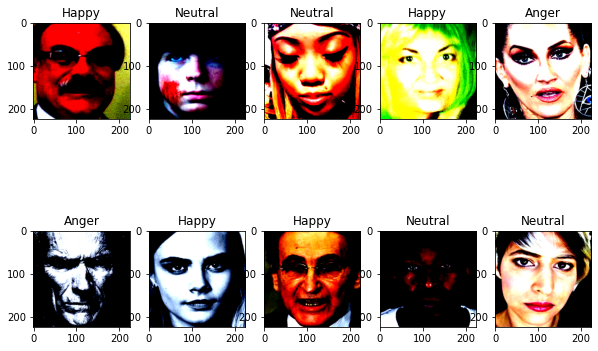

In [19]:
display_some_images(train_data)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

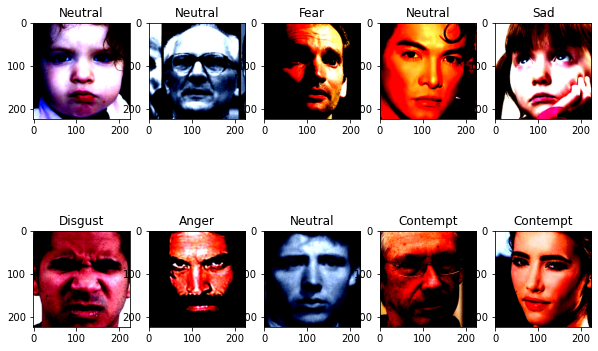

In [20]:
display_some_images(val_data)

In [21]:
a,b=train_data[0]
stats_of_image_and_label(a,b)


<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
torch.Size([])
torch.float32
torch.float32


In [22]:
Subset_train_sampler=subset_generator(train_data,50000)

In [23]:
train_loader=torch.utils.data.DataLoader(train_data,
                                         batch_size=batch,
                                         shuffle=False,
                                         num_workers=4,
                                         pin_memory=True,
                                         sampler=Subset_train_sampler)
val_loader=torch.utils.data.DataLoader(val_data,
                                       batch_size=batch,
                                       shuffle=False,
                                       num_workers=4,
                                       pin_memory=True,
                                      sampler=None)

In [24]:
print(len(train_loader))
print(len(val_loader))

3125
250


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [26]:
feature_extractor=vgg_all_freezed()
total_trainable_parameters(feature_extractor)


Total trainable parameters of Sequential is 	 0


In [27]:

#input_features_for_denselayer=get_output_features_of_model(model=feature_extractor,batch_size=32,dataloader=train_loader)
input_features_for_denselayer=25088


In [31]:
class Network(nn.Module):
  def __init__(self,feature_extractor,input_features_for_denselayer):
    super(Network, self).__init__()
    self.extractor=feature_extractor
    self.RHC=nn.Sequential(
                          nn.Linear(input_features_for_denselayer,4096),
                          nn.ReLU(inplace=True),
                          nn.Dropout(p=0.5,inplace=False),
                          nn.Linear(4096,1024),
                          nn.ReLU(inplace=True),
                          nn.Dropout(p=0.5,inplace=False),
                          nn.Linear(1024,128),
                          nn.ReLU(inplace=True),
                          nn.Dropout(p=0.5,inplace=False),
                          nn.Linear(128,16),
                          nn.ReLU(inplace=True),
                          nn.Linear(16,8))
    self.input_features_for_denselayer=input_features_for_denselayer
    
  def forward(self,x):
    x=self.extractor(x)
    x=x.view(-1,self.input_features_for_denselayer)
    x=self.RHC(x)
    return x
model1=Network(feature_extractor,input_features_for_denselayer).to(device)
model1

Network(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [33]:
total_trainable_parameters(model1)


Total trainable parameters of Network is 	 107093272


In [19]:
""""
for m1,n1 in train_loader:
    m1,n1=m1,n1
    break
m1.shape
p=model1(m1.to(device))
p.shape
"""

'"\nfor m1,n1 in train_loader:\n    m1,n1=m1,n1\n    break\nm1.shape\np=model1(m1.to(device))\np.shape\n'

In [34]:
lr=0.001
loss1=nn.CrossEntropyLoss()
optimizer=optim.SGD(model1.parameters(),lr,momentum=0.9)

In [21]:
#torch.backends.cudnn.benchmark = True

In [35]:
len(train_loader)

3125

In [36]:
def train(dataloader,model,loss_fn,optimizer):
    model.train()
    for batch,(X,y) in enumerate(tqdm(dataloader)):
        y = y.type(torch.LongTensor)
        X,y=X.to(device),y.to(device)

        pred=model(X)
        loss=loss_fn(pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss=loss.item()
    print(f'loss:{loss:>5f}',f'batch:{batch}/{len(dataloader)}')  

In [37]:
def validation(dataloader,model,loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss,correct=0,0
    with torch.no_grad():
        for batch,(X,y) in enumerate(tqdm(dataloader)):
            y = y.type(torch.LongTensor)
            X,y=X.to(device),y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).sum().item()
    test_loss/=num_batches
    correct/=size
    print(f'test error-{test_loss:>5f} \n Accuracy-{correct*100:>3f}%')

In [40]:
epochs=100
for epoch in range(epochs):
    print(f'Epoch-{epoch}')
    train(train_loader,model1,loss1,optimizer)
    validation(val_loader,model1,loss1)

  


Epoch-0


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [19:09<00:00,  2.72it/s]


loss:0.455343 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:57<00:00,  4.34it/s]


test error-2.203296 
 Accuracy-31.482871%
Epoch-1


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:17<00:00,  3.92it/s]


loss:0.503107 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:01<00:00,  4.09it/s]


test error-2.289593 
 Accuracy-29.857464%
Epoch-2


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:35<00:00,  3.83it/s]


loss:0.777483 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:01<00:00,  4.10it/s]


test error-2.368354 
 Accuracy-30.407602%
Epoch-3


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:39<00:00,  3.82it/s]


loss:1.121089 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:02<00:00,  4.03it/s]


test error-2.160344 
 Accuracy-32.933233%
Epoch-4


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:40<00:00,  3.81it/s]


loss:0.905702 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:02<00:00,  4.03it/s]


test error-2.376098 
 Accuracy-31.807952%
Epoch-5


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:43<00:00,  3.80it/s]


loss:0.561356 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:05<00:00,  3.81it/s]


test error-2.353080 
 Accuracy-33.033258%
Epoch-6


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:49<00:00,  3.77it/s]


loss:0.493698 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:05<00:00,  3.84it/s]


test error-2.360169 
 Accuracy-32.058015%
Epoch-7


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:39<00:00,  3.81it/s]


loss:1.255179 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:10<00:00,  3.53it/s]


test error-2.481437 
 Accuracy-33.333333%
Epoch-8


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:50<00:00,  3.76it/s]


loss:0.813214 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:03<00:00,  3.93it/s]


test error-2.631454 
 Accuracy-32.183046%
Epoch-9


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:52<00:00,  3.75it/s]


loss:0.442152 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:16<00:00,  3.29it/s]


test error-2.721600 
 Accuracy-32.033008%
Epoch-10


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:37<00:00,  3.82it/s]


loss:0.099069 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:28<00:00,  2.83it/s]


test error-2.610489 
 Accuracy-34.058515%
Epoch-11


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [14:16<00:00,  3.65it/s]


loss:0.592612 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:04<00:00,  3.88it/s]


test error-2.666787 
 Accuracy-35.083771%
Epoch-12


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [15:47<00:00,  3.30it/s]


loss:0.294271 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:01<00:00,  4.05it/s]


test error-2.937008 
 Accuracy-32.233058%
Epoch-13


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [17:00<00:00,  3.06it/s]


loss:0.215278 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:59<00:00,  4.20it/s]


test error-2.790851 
 Accuracy-33.608402%
Epoch-14


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [14:10<00:00,  3.68it/s]


loss:0.203218 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:12<00:00,  3.43it/s]


test error-3.207068 
 Accuracy-32.808202%
Epoch-15


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [13:54<00:00,  3.74it/s]


loss:0.262966 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:03<00:00,  3.94it/s]


test error-3.188397 
 Accuracy-33.783446%
Epoch-16


100%|██████████████████████████████████████████████████████████████████████████████| 3125/3125 [16:41<00:00,  3.12it/s]


loss:1.321511 batch:3124/3125


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [01:00<00:00,  4.13it/s]


test error-3.271809 
 Accuracy-33.383346%
Epoch-17


 74%|█████████████████████████████████████████████████████████▋                    | 2309/3125 [16:05<05:41,  2.39it/s]


KeyboardInterrupt: 

In [42]:
validation(val_loader,model1,loss1)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:56<00:00,  4.39it/s]

test error-3.169820 
 Accuracy-34.583646%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


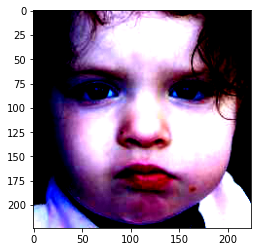

C:\Users\DELL\AppData\Local\Temp\ipykernel_3660\839092812.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_x,pred_y=pred_x.to(device),(torch.tensor(pred_y)).to(device)


real value is  Neutral


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted is Neutral


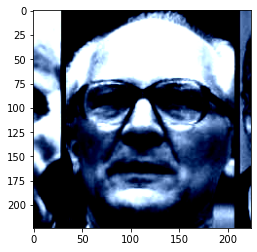

real value is  Neutral
predicted is Neutral


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


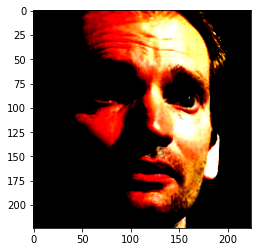

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real value is  Fear
predicted is Neutral


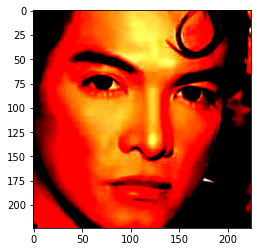

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real value is  Neutral
predicted is Neutral


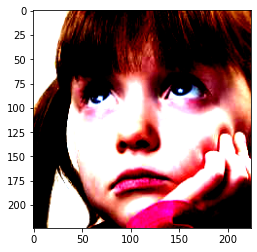

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real value is  Sad
predicted is Surprise


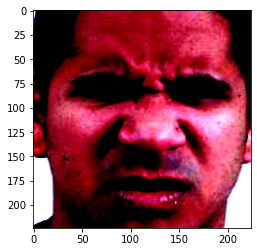

real value is  Disgust
predicted is Disgust


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


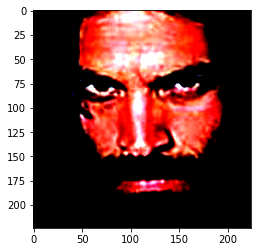

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real value is  Anger
predicted is Anger


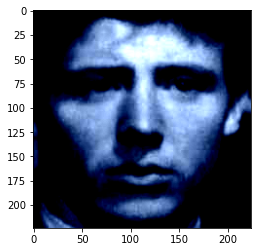

real value is  Neutral


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted is Neutral


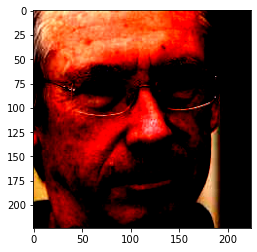

real value is  Contempt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted is Happy


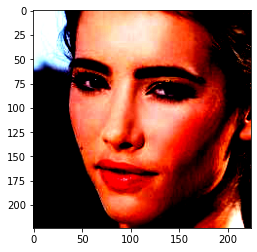

real value is  Contempt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted is Neutral


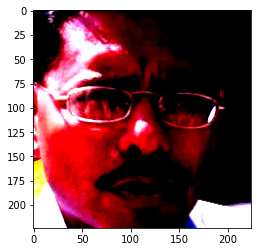

real value is  Anger
predicted is Happy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


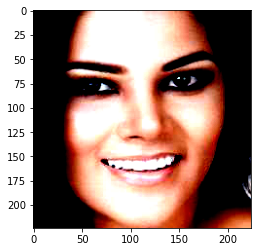

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real value is  Happy
predicted is Happy


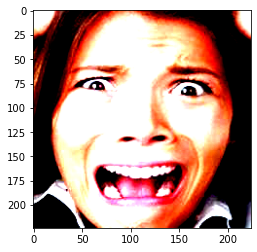

real value is  Fear
predicted is Fear


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


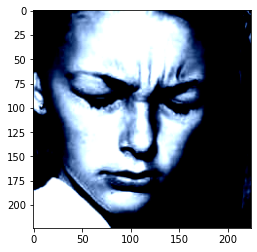

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real value is  Sad
predicted is Anger


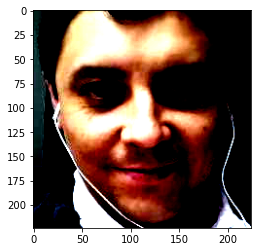

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real value is  Contempt
predicted is Neutral


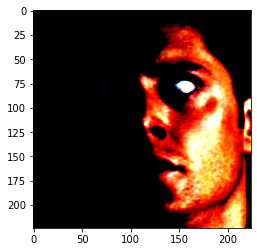

real value is  Fear


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted is Fear


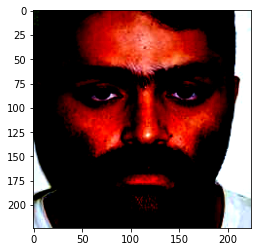

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


real value is  Sad
predicted is Anger


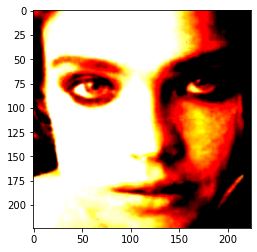

real value is  Fear


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted is Neutral


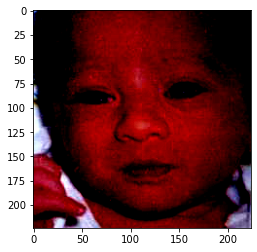

real value is  Sad


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted is Neutral


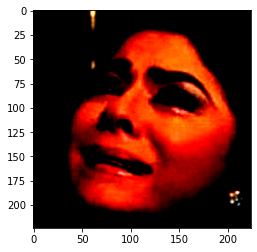

real value is  Sad
predicted is Happy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


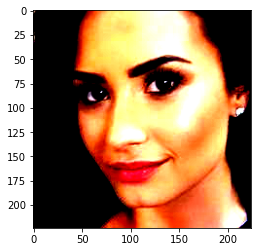

real value is  Contempt
predicted is Neutral


In [41]:
def image_validation(model)
model1.eval()
classes=['Neutral','Happy','Sad','Surprise','Fear','Disgust','Anger','Contempt']
test_loader=torch.utils.data.DataLoader(val_data,batch_size=None,shuffle=False)
count=0
for pred_x,pred_y in test_loader:
    if count>20:
        
        break
    plt.imshow(pred_x.permute(1,2,0).squeeze(2))
    plt.show()
    pred_x,pred_y=pred_x.to(device),(torch.tensor(pred_y)).to(device)
    print('real value is ',classes[int(pred_y)])
    with torch.no_grad():
        pred=model1(pred_x.unsqueeze(0))
        predicted=pred.argmax(1)
        print('predicted is',classes[predicted])
    count+=1